# Build neighbourhood VDJ feature space

In [1]:
import numpy as np
import seaborn as sns
import os
import pandas as pd
import scanpy as sc
import dandelion as ddl
import palantir
import scipy as sp
ddl.logging.print_header()
import matplotlib.pyplot as plt

findfont: Font family ['Raleway'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Lato'] not found. Falling back to DejaVu Sans.


dandelion==0.3.1 pandas==1.4.4 numpy==1.23.5 matplotlib==3.7.1 networkx==3.1 scipy==1.10.1


In [2]:
import matplotlib.pyplot as plt

In [3]:
sc.logging.print_header()

/home/jovyan/my-conda-envs/sc-dandelion/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


scanpy==1.9.1 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.0 pandas==1.4.4 scikit-learn==1.2.0 statsmodels==0.13.5 python-igraph==0.10.2 pynndescent==0.5.8


In [6]:
import matplotlib.pyplot as plt
sc.settings.set_figure_params(dpi = 160, color_map = 'RdYlBu_r', dpi_save = 300, format = 'pdf')
plt.rcParams["figure.figsize"] = [6,6]
sns.set_palette('colorblind')

In [8]:
#### need to add this line to restore plotting function of scanpy in the presence of palantir
%matplotlib inline

# Load data

In [10]:
# object loaded with abTCR
adata_abtcr = sc.read('Thymus_Atlas_v13_abTCR.h5ad')
adata_abtcr

AnnData object with n_obs × n_vars = 126034 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_r

In [16]:
pd.options.display.max_rows = 100
adata_abtcr.obs['annotation_level_3'].value_counts()

T_DP(Q)                29639
T_DP(P)-2              12068
T_αβT(entry)           11283
T_DP(P)-1               9174
T_DP(P)-3               7176
T_CD4                   6735
T_CD8                   6032
T_CD8αα(I)              3521
T_reg(agonist)          3491
T_DP(P)-4               3145
ambiguous               2861
T_DN(CD25)              2808
T_DP(Q)-HSPH1           2786
T_DN(Q)                 2689
T_DN(P)                 2688
T_DP(Q)-CD99            2141
T_SP-HSP                1965
T_reg                   1351
T_CD8αα(II)             1294
T_CD8αα(entry)          1244
T_reg(diff)-FOXP3hi     1139
T_CD8-Prolif             997
PeriloFb                 878
T_γδT                    731
T_NK                     709
cTECIII                  665
cTECII                   456
T_DN(early)              446
unassigned               435
mTECI                    425
B-stimulated             414
DC1                      408
T_reg(diff)-FOXP3Lo      401
DC-a3                    368
InterloFb     

In [48]:
# set up subsets and colors
ct_order = ['T_DN(early)','T_DN(P)','T_DN(Q)','T_DN(CD25)','T_DP(P)-1','T_DP(P)-2','T_DP(P)-3','T_DP(P)-4','T_DP(Q)','T_DP(Q)-HSPH1','T_DP(Q)-CD99','T_αβT(entry)','T_CD4','T_CD8','T_CD8-Prolif']
ct_color_map = dict(zip(ct_order, np.array(sns.color_palette('tab20'))[range(len(ct_order))]))

# Filter cells

### Subset cells to DP onwards, and cells with paired TCRab

In [49]:
# utility function to setup the data to only contain cells with VDJ info.
bdata = ddl.tl.setup_vdj_pseudobulk(adata_abtcr, 
                                    mode='abT',
                                    subsetby='annotation_level_3', 
                                    groups = ct_order, 
                                    productive_vdj=False, 
                                    productive_vj=False,
                                    check_vdj_mapping=None,
                                    check_vj_mapping=None,
                                   #filter_pattern = None,
                                   #allowed_chain_status=None
                                   )


In [50]:
bdata.obs['j_call_abT_VDJ_main'].value_counts()

TRBJ2-7    13254
TRBJ2-1    10411
TRBJ1-1    10163
TRBJ2-3     9736
TRBJ1-2     9347
TRBJ2-5     7123
TRBJ1-5     5794
TRBJ2-2     5473
TRBJ1-6     3543
TRBJ1-4     3365
TRBJ1-3     2939
TRBJ2-4     1841
TRBJ2-6     1476
Name: j_call_abT_VDJ_main, dtype: int64

In [51]:
# change all entries with ',' (inconfident mappings) to 'None'
for chain in ['v_call_abT_VDJ_main', 'j_call_abT_VDJ_main','v_call_abT_VJ_main', 'j_call_abT_VJ_main']:
    bdata.obs[chain] = bdata.obs[chain].astype('object')
    for cell in bdata.obs_names:
        gene = bdata.obs.loc[cell, chain]
        if ',' in gene or gene =='None' or gene =='No_contig':
            bdata.obs.loc[cell, chain] = chain+'_None'
    bdata.obs[chain] = bdata.obs[chain].astype('category')

In [52]:
# remove one cell that has TRBJ2-7 in j_call_abT_VJ_main
bdata = bdata[~(bdata.obs['j_call_abT_VJ_main']=='TRBJ2-7')]
bdata

View of AnnData object with n_obs × n_vars = 84465 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_coun

In [54]:
bdata.write('Thymus_Atlas_v13_abTCR_filetered.h5ad')

# Select neighbourhoods 

In [34]:
## need to redo neighborhood graph after subsetting cells before milo
# n_neighbors decides the minimum neighbourhood size 
# here use_rep = 'X_scvi' as data integration was done using scVI
sc.pp.neighbors(bdata, use_rep = "X_scVI", n_neighbors = 50)
sc.tl.umap(bdata, random_state = 1712)

In [35]:
# take a look at the UMAP to make sure it looks reasonable i.e. different cell types are clustered separately
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [5.5,5]
sc.pl.umap(bdata, color=['annotation_level_3'], palette = ct_color_map, legend_loc = 'on data', legend_fontsize=10)

In [36]:
bdata.obs['annotation_level_3'].value_counts()

T_DP(Q)          27039
T_DP(P)-2        11001
T_αβT(entry)     10395
T_DP(P)-1         8306
T_DP(P)-3         6635
T_CD4             6222
T_CD8             5572
T_DP(P)-4         2873
T_DP(Q)-HSPH1     2562
T_DP(Q)-CD99      1931
T_CD8-Prolif       946
T_DN(CD25)         416
T_DN(Q)            289
T_DN(P)            249
T_DN(early)         29
T_DN(P)-early        6
ETP                  4
Name: annotation_level_3, dtype: int64

In [38]:
import milopy
import milopy.core as milo

# use milo to sample neighbourhood
milo.make_nhoods(bdata)
# build neighbourhood adata in bdata.uns['nhood_adata']
milo.count_nhoods(bdata, sample_col='sample') # this step is needed to build bdata.uns['nhood_adata'] and sample_col can be anything
# this step is needed for plotting below
milopy.utils.build_nhood_graph(bdata)
# assign neighbourhood celltype by majority voting
# results are in bdata.uns['nhood_adata'].obs['nhood_annotation'] & bdata.uns['nhood_adata'].obs['nhood_annotation_frac'] 
milopy.utils.annotate_nhoods(bdata, anno_col='annotation_level_3')
bdata

/home/jovyan/my-conda-envs/sc-dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 84475 × 36751
    obs: 'n_genes', 'sample_barcode', 'batch', 'chemistry', 'age_group', 'age_numeric', 'sampleID_TCRab', 'path_TCRab', 'type', 'study', 'sample', 'enrichment', 'doublet_score', 'predicted_doublet', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'pct_counts_hb', 'percent_mt2', 'n_counts', 'barcode_sequence', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'log1p_total_counts_mt', 'status', 'assignment', 'log_prob_singleton', 'log_prob_doublet', 'louvian_1', 'louvian_05', 'latent_cell_probability', 'latent_RT_efficiency', 'log1p_n_counts', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_ra

In [39]:
# histogram to look at neighbourhood sizes ### optional
plt.rcParams["figure.figsize"] = [4,4]
plt.hist(np.array(bdata.obsm["nhoods"].sum(0)).flatten(), bins=50);
plt.title('neighborhood sizes')
plt.xlabel('number of cells in the neighborhood')
plt.ylabel('proportion (%) of neighborhoods')
#plt.savefig(fig_path+'TCR_neighbourhood_size.pdf')

Now neighbourhood adata is stored in bdata.uns['nhood_adata']

In [40]:
bdata.uns['nhood_adata']

AnnData object with n_obs × n_vars = 6053 × 25
    obs: 'index_cell', 'kth_distance', 'Nhood_size', 'nhood_annotation', 'nhood_annotation_frac'
    uns: 'sample_col', 'nhood', 'annotation_labels', 'annotation_obs'
    obsm: 'X_milo_graph', 'frac_annotation'
    obsp: 'nhood_connectivities'

In [41]:
tmp = bdata.obs[['v_call_abT_VDJ_main', 'j_call_abT_VDJ_main','v_call_abT_VJ_main', 'j_call_abT_VJ_main']]

In [42]:
np.sum(tmp.isna())

v_call_abT_VDJ_main    0
j_call_abT_VDJ_main    0
v_call_abT_VJ_main     0
j_call_abT_VJ_main     0
dtype: int64

# Create neighbourhood VDJ feature space

In [43]:
from anndata import AnnData
from typing import List, Optional, Union
import scipy as sp
def _get_pbs(pbs, obs_to_bulk, adata):
    """
    Helper function to ensure we have a cells by pseudobulks matrix which we can use for
    pseudobulking. Uses the pbs and obs_to_bulk inputs to vdj_pseudobulk() and
    gex_pseudobulk().
    """
    # well, we need some way to pseudobulk
    if pbs is None and obs_to_bulk is None:
        raise ValueError(
            "You need to specify `pbs` or `obs_to_bulk` when calling the function"
        )

    # but just one
    if pbs is not None and obs_to_bulk is not None:
        raise ValueError("You need to specify `pbs` or `obs_to_bulk`, not both")

    # turn the pseubodulk matrix dense if need be
    if pbs is not None:
        if sp.sparse.issparse(pbs):
            pbs = pbs.todense()

    # get the obs-derived pseudobulk
    if obs_to_bulk is not None:
        if type(obs_to_bulk) is list:
            # this will create a single value by pasting all the columns together
            tobulk = adata.obs[obs_to_bulk].T.astype(str).agg(",".join)
        else:
            # we just have a single column
            tobulk = adata.obs[obs_to_bulk]
        # this pandas function creates the exact pseudobulk assignment we want
        # this needs to be different than the default uint8
        # as you can have more than 255 cells in a pseudobulk, it turns out
        pbs = pd.get_dummies(tobulk, dtype="uint16").values
    return pbs
def _get_pbs_obs(pbs, obs_to_take, adata):
    """
    Helper function to create the pseudobulk object's obs. Uses the pbs and obs_to_take
    inputs to vdj_pseudobulk() and gex_pseudobulk().
    """
    # prepare per-pseudobulk calls of specified metadata columns
    pbs_obs = pd.DataFrame(index=np.arange(pbs.shape[1]))
    if obs_to_take is not None:
        # just in case a single is passed as a string
        if type(obs_to_take) is not list:
            obs_to_take = [obs_to_take]
        # now we can iterate over this nicely
        # using the logic of milopy's annotate_nhoods()
        for anno_col in obs_to_take:
            anno_dummies = pd.get_dummies(adata.obs[anno_col])
            # this needs to be turned to a matrix so dimensions get broadcast correctly
            anno_count = np.asmatrix(pbs).T.dot(anno_dummies.values)
            anno_frac = np.array(anno_count / anno_count.sum(1))
            anno_frac = pd.DataFrame(
                anno_frac,
                index=np.arange(pbs.shape[1]),
                columns=anno_dummies.columns,
            )
            pbs_obs[anno_col] = anno_frac.idxmax(1)
            pbs_obs[anno_col + "_fraction"] = anno_frac.max(1)
    # report the number of cells for each pseudobulk
    # ensure pbs is an array so that it sums into a vector that can go in easily
    pbs_obs["cell_count"] = np.sum(np.asarray(pbs), axis=0)
    return pbs_obs

def vdj_pseudobulk(
    adata: AnnData,
    pbs: Optional[Union[np.ndarray, sp.sparse.csr_matrix]] = None,
    obs_to_bulk: Optional[Union[str, List[str]]] = None,
    obs_to_take: Optional[Union[str, List[str]]] = None,
    cols: Optional[List[str]] = None,
) -> AnnData:
    """Function for making pseudobulk vdj feature space. One of `pbs` or `obs_to_bulk`
    needs to be specified when calling.
    Parameters
    ----------
    adata : AnnData
        Cell adata, preferably after `ddl.tl.setup_vdj_pseudobulk()`
    pbs : Optional[Union[np.ndarray, sp.sparse.csr_matrix]], optional
        Optional binary matrix with cells as rows and pseudobulk groups as columns
    obs_to_bulk : Optional[Union[str, List[str]]], optional
        Optional obs column(s) to group pseudobulks into; if multiple are provided, they
        will be combined
    obs_to_take : Optional[Union[str, List[str]]], optional
        Optional obs column(s) to identify the most common value of for each pseudobulk.
    cols : Optional[List[str]], optional
        If provided, use the specified obs columns to extract V(D)J calls
    Returns
    -------
    AnnData
        pb_adata, whereby each observation is a pseudobulk:\n
        VDJ usage frequency stored in pb_adata.X\n
        VDJ genes stored in pb_adata.var\n
        pseudobulk metadata stored in pb_adata.obs\n
        pseudobulk assignment (binary matrix with input cells as columns) stored in pb_adata.obsm['pbs']\n
    """
    # get our cells by pseudobulks matrix
    pbs = _get_pbs(pbs, obs_to_bulk, adata)

    # if not specified by the user, use the following default dandelion VJ columns
    if cols is None:
        cols = [i for i in adata.obs if re.search("_VDJ_main|_VJ_main", i)]

    # perform matrix multiplication of pseudobulks by cells matrix by a cells by VJs matrix
    # start off by creating the cell by VJs matrix, using the pandas dummies again
    # skip the prefix stuff as the VJ genes will be unique in the columns
    vjs = pd.get_dummies(adata.obs[cols], prefix="", prefix_sep="")
    # TODO: DENAN SOMEHOW? AS IN NAN GENES?
    # can now multiply transposed pseudobulk assignments by this vjs thing, turn to df
    vj_pb_count = pbs.T.dot(vjs.values)
    df = pd.DataFrame(
        vj_pb_count, index=np.arange(pbs.shape[1]), columns=vjs.columns
    )

    # loop over V(D)J gene categories
    #for col in cols:
        # identify columns holding genes belonging to the category
        # and then normalise the values to 1 for each pseudobulk
        #mask = np.isin(df.columns, np.unique(adata.obs[col]))
        #df.loc[:, mask] = df.loc[:, mask].div(
            #df.loc[:, mask].sum(axis=1), axis=0
        #)

    # create obs for the new pseudobulk object
    pbs_obs = _get_pbs_obs(pbs, obs_to_take, adata)

    # store our feature space and derived metadata into an AnnData
    pb_adata = sc.AnnData(
        np.array(df), var=pd.DataFrame(index=df.columns), obs=pbs_obs
    )
    # store the pseudobulk assignments, as a sparse for storage efficiency
    # transpose as the original matrix is cells x pseudobulks
    pb_adata.obsm["pbs"] = sp.sparse.csr_matrix(pbs.T)
    return pb_adata

In [44]:
# function for making neighbourhood vdj feature space
nhood_adata = vdj_pseudobulk(bdata, pbs = bdata.obsm['nhoods'], obs_to_take = 'annotation_level_3', cols=['v_call_abT_VDJ_main', 'j_call_abT_VDJ_main','v_call_abT_VJ_main', 'j_call_abT_VJ_main'])
nhood_adata

/home/jovyan/my-conda-envs/sc-dandelion/lib/python3.10/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.


AnnData object with n_obs × n_vars = 6053 × 166
    obs: 'annotation_level_3', 'annotation_level_3_fraction', 'cell_count'
    obsm: 'pbs'

In [360]:
ncell = nhood_adata.shape[0]
nhood_size = nhood_adata.obs['cell_count']
cols=['v_call_abT_VDJ_main', 'j_call_abT_VDJ_main','v_call_abT_VJ_main', 'j_call_abT_VJ_main']
for col in cols:
    mask = np.isin(nhood_adata.var_names, np.unique(bdata.obs[col]))
    
    # normalise including None
    genes = nhood_adata.var_names[mask]
    df = pd.DataFrame(data = nhood_adata[:,genes].X.copy(), columns = genes)
    df = df / np.array(np.sum(df, axis=1)).reshape(ncell,1) # this is the same as /nhood_adata.obs['cell_count']

    # normalise excluding None 
    genes2 = [gene for gene in genes if gene != col+'_None']
    df2 = pd.DataFrame(data = nhood_adata[:,genes2].X.copy(), columns = genes2)
    df2 = df2 / np.array(np.sum(df2, axis=1)).reshape(ncell,1)
    # if expressing cell number < 10, then everything in df2 set to 0
    nhood_select = np.array(nhood_size) * np.array(1-df[col+'_None']) < 10
    df2.loc[nhood_select, :] = 0
    
    # combine dataframe and replace .X with normalised data
    df_combine = pd.concat([df2, df[col+'_None']], axis=1)
    nhood_adata[:,df_combine.columns].X = df_combine

In [45]:
# fill nan with 0 (as e.g. one neighborhood doesn't have any TRBV, then it would be nan for all TRBV genes, but 1 for v_call_abT_VDJ_main_None)
nhood_adata.X = np.nan_to_num(nhood_adata.X, copy=True, nan=0, posinf=None, neginf=None)

     nhood_adata is the new neighbourhood VDJ feature space, whereby each observation is a cell neighbourhood
     VDJ usage frequency stored in nhood_adata.X
     VDJ genes stored in nhood_adata.var
     neighbourhood metadata stored in nhood_adata.obs
     can visualise the data using PCA or UMAP (see below)

In [46]:
# # sort out the annotation colour order
nhood_adata.obs['annotation_level_3'] = nhood_adata.obs['annotation_level_3'].astype('category')
nhood_adata.obs['annotation_level_3'] = nhood_adata.obs['annotation_level_3'].cat.reorder_categories(ct_order)

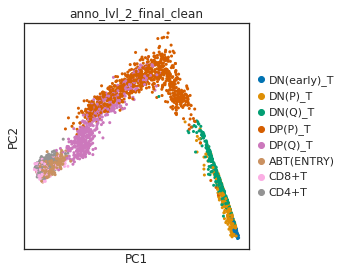

In [363]:
sc.pp.pca(nhood_adata, random_state = 1712)
sc.pl.pca(nhood_adata, color=['anno_lvl_2_final_clean'], palette=ct_color_map)

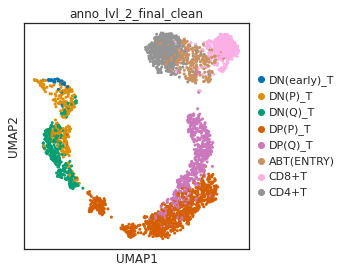

In [364]:
sc.pp.neighbors(nhood_adata, random_state = 1712)
sc.tl.umap(nhood_adata, random_state = 1712)
sc.pl.umap(nhood_adata, color=['anno_lvl_2_final_clean'], palette=ct_color_map)

### Run Pseudotime on VDJ feature space

In [365]:
# make sure you install palantir if you don't already have it

# Run diffusion maps
pca_projections = pd.DataFrame(nhood_adata.obsm['X_pca'], index=nhood_adata.obs_names)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)

Determing nearest neighbor graph...


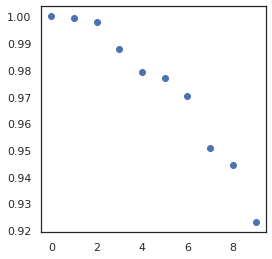

In [366]:
plt.scatter(np.arange(10), dm_res['EigenValues'])

In [367]:
ms_data = palantir.utils.determine_multiscale_space(dm_res, n_eigs=7)

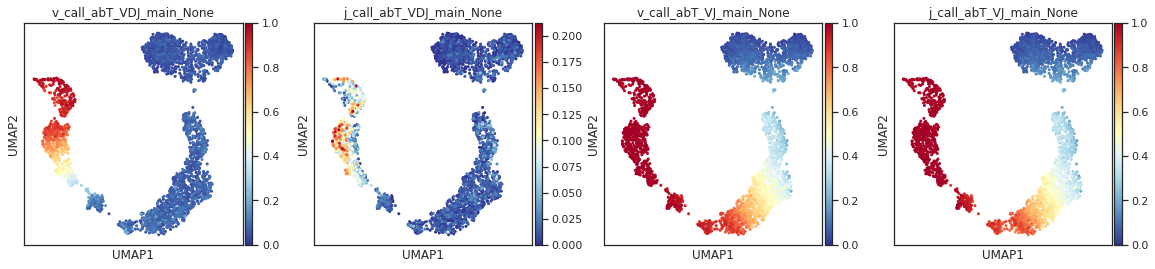

In [368]:
plt.rcParams["figure.figsize"] = [4,4]
sc.pl.umap(nhood_adata, color=[col + '_None' for col in cols],color_map = 'RdYlBu_r')

In [369]:
# select the start and end points
# start
#tmp = nhood_adata[nhood_adata.obs['anno_lvl_2_final_clean'] == 'DP(P)_T']
tmp = nhood_adata[nhood_adata.obs['anno_lvl_2_final_clean'] == 'DN(early)_T']
rootcell = np.argmax(tmp.obsm['X_umap'][:,1])
rootcell = tmp.obs_names[rootcell]
nhood_adata.obs['rootcell'] = 0
nhood_adata.obs.loc[rootcell,'rootcell'] = 1

In [370]:
# ends
tmp1 = nhood_adata[nhood_adata.obs['anno_lvl_2_final_clean'] == 'CD8+T']
tmp2 = nhood_adata[nhood_adata.obs['anno_lvl_2_final_clean'] == 'CD4+T']
endcell1 = np.argmax(tmp1.obsm['X_umap'][:,0])
endcell1 = tmp1.obs_names[endcell1]
endcell2 = np.argmin(tmp2.obsm['X_umap'][:,0])
endcell2 = tmp2.obs_names[endcell2]

terminal_states = pd.Series(['CD8+T', 'CD4+T'], 
                           index=[endcell1,endcell2])

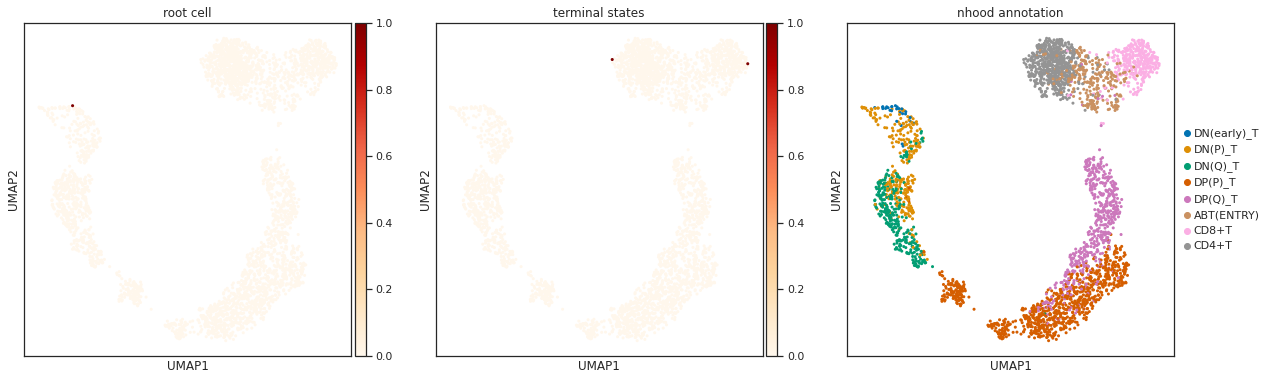

In [371]:
# plot rootcell and terminal states
nhood_adata.obs['terminal_states'] = 0
nhood_adata.obs.loc[terminal_states.index, 'terminal_states'] = 1
plt.rcParams["figure.figsize"] = [6,6]
sc.pl.umap(nhood_adata,color=['rootcell','terminal_states','anno_lvl_2_final_clean'],
           title=['root cell','terminal states','nhood annotation'],color_map='OrRd')

In [372]:
pr_res = palantir.core.run_palantir(ms_data,  rootcell, num_waypoints=500, 
                                    terminal_states = terminal_states.index)

Sampling and flocking waypoints...
Time for determining waypoints: 0.0020433545112609865 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.032757612069447835 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 1.0000
Entropy and branch probabilities...
Markov chain construction...
Computing fundamental matrix and absorption probabilities...


/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:447: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
/home/jovyan/my-conda-envs/palantir/lib/python3.8/site-packages/palantir/core.py:450: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


Project results to all cells...


In [373]:
pr_res.branch_probs.columns = terminal_states[pr_res.branch_probs.columns]

## Visualise the data

In [374]:
ddl.tl.pseudotime_transfer(adata = nhood_adata, pr_res = pr_res, suffix = '_nhood_vdj')

AnnData object with n_obs × n_vars = 3244 × 175
    obs: 'anno_lvl_2_final_clean', 'anno_lvl_2_final_clean_fraction', 'cell_count', 'rootcell', 'terminal_states', 'pseudotime_nhood_vdj', 'prob_CD8+T_nhood_vdj', 'prob_CD4+T_nhood_vdj'
    uns: 'pca', 'anno_lvl_2_final_clean_colors', 'neighbors', 'umap'
    obsm: 'pbs', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

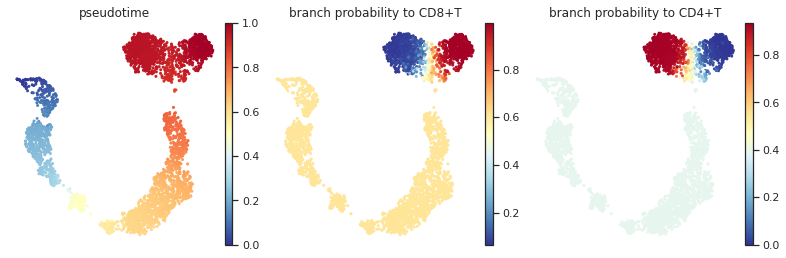

In [375]:
plt.rcParams["figure.figsize"] = [4,4]
plot = ['pseudotime', 'prob_CD8+T', 'prob_CD4+T']
sc.pl.umap(nhood_adata,color=[term + '_nhood_vdj' for term in plot],
           title=['pseudotime','branch probability to CD8+T',
                  'branch probability to CD4+T'],
           frameon=False,wspace=0.1,
           color_map = 'RdYlBu_r'
          )